# Behavioral Cloning for Autonomous Driving

In this project, we will be teaching a car in a simulator to drive autonomously. To give you an idea of what we will be teaching the car to do, the following video shows one lap of me driving the car non-autonomously around the course. The goal of this project is to get the car to mimic how I drive the car, which is known in the lexicon of machine learning as ** *behavioral cloning***. 

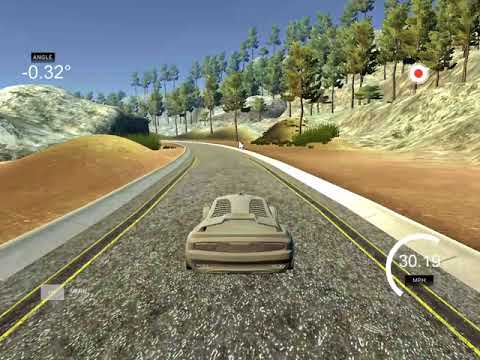

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('8pHoTjH-FnA')

The above example is just a quick run-through to demonstrate what the course looks like and what I roughly expect the car to do. It is important to note that the above video shows a birds-eye view of the car driving around the course, typical of what you would find in a video game. Do we have images like that in the real world? No. No we don't. 

In practice, we are trying to mimic a real-life situation in which we don't have a helicopter following a car the whole time. That means we will have to rely on cameras mounted on the car. For the purposes of this project, we have three cameras mounted on the front car: in the left, right, and center:     

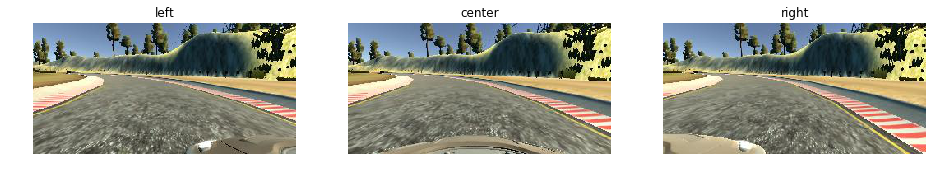

In [2]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib 

# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(16, 12))
images = [ 'left', 'center', 'right' ]
for i,image in enumerate(images):
    ax = plt.subplot(1,3,i+1)
    ax.imshow(mpimg.imread('images/' + image + '.jpg'))
    ax.axis('off')
    plt.title(image)

Just to give you an idea of what this looks like in the simulator, the birdseye perspective of the above scene looks like this

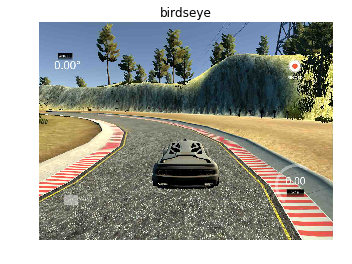

In [3]:
fig = plt.figure()
image = 'birdseye'
plt.imshow(mpimg.imread('images/' + image + '.jpg'));
plt.axis('off');
plt.title(image);

## Reference Data

As with any machine learning project, your model will only be as good as the data you give it. If you train the model on bad data, then you will also get poor results. I mention this because I was given a relatively large test set in which someone drove the car around the track a few times. I decided to ignore this data because the test drives were very *jerky* (for lack of a better word). I presume that this is because there are two methods of controlling the car in the simulator: with the mouse, and with the arrow keys. With the mouse, you tend to get a nice, smooth response, like at the top of this description. With the arrow keys, you tend to get a more jerky response, which is not symbolic of how I would actually want an autonomous car to drive:   

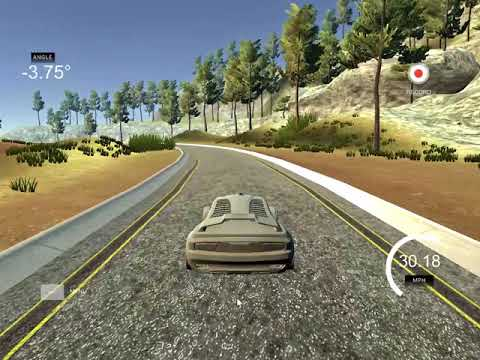

In [4]:
YouTubeVideo('HaK3SIsWA8k')

The important take away form the above video is that, when using the arrow keys, you will find that car is given a steering command of 0 most of the time, and then a very quick, large, nonzero value when corrective action needs to be taken. I am not saying that you can't train a car to drive using such data, but that the result will probably be a very jerky response. For completeness, here is a video showing the provided data (which is not used in the remainder of this project). You should notice that the control commands jump between 0 and large nonzero values. Also, note that the video shows the left, center, and right images, with the steering angle (in degrees) shown over the center image:  

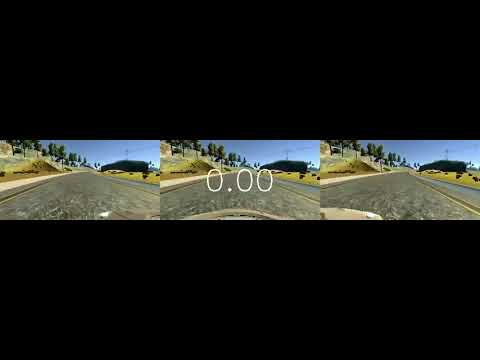

In [5]:
YouTubeVideo('YfEOmNqzVL4')

## Custom Data

### Centered Data

Since we have decided to abandon the provided dataset, we are going to have to generate our own. We have decided to focus on 3 of the curves, one of the straightaways, and the bridge. For each of these *scenes*, we drive that part of the course multiple times in the ideal conditions (as close to "right down the center" as we could get). Later we will split each of the datasets into training and validation portions. But just to give you an easy way to view the scene data, we put them together into videos for easy viewing. Also, note that we break the data down by scenes, since it should be easier to replace if one of the datasets turns out to cause us problems.

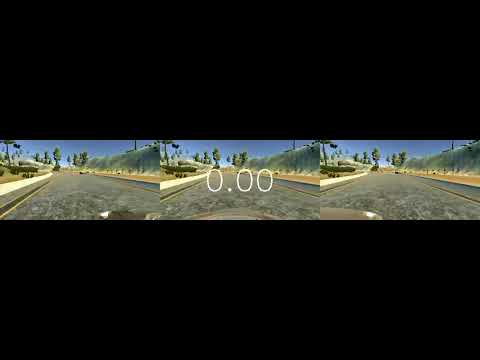

In [6]:
YouTubeVideo('MQ22diVVh7s')

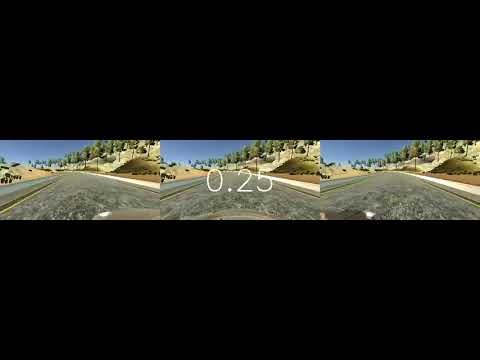

In [7]:
YouTubeVideo('PzE12M2rqWQ')

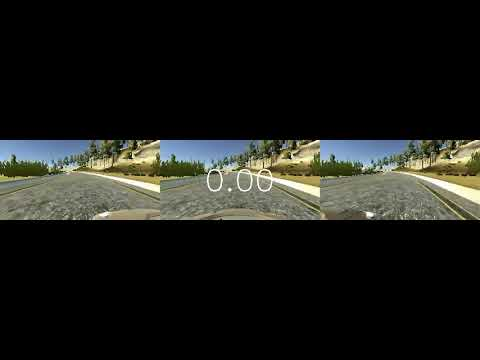

In [8]:
YouTubeVideo('ifjMBAn_jjw')

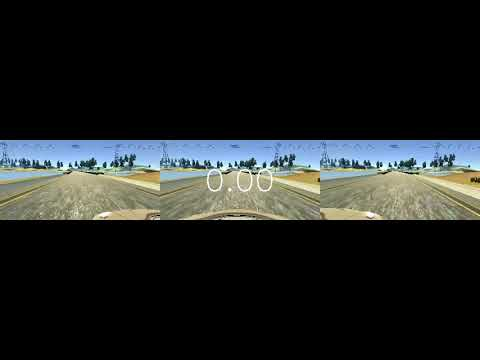

In [9]:
YouTubeVideo('PTjIgVBQ9lg')

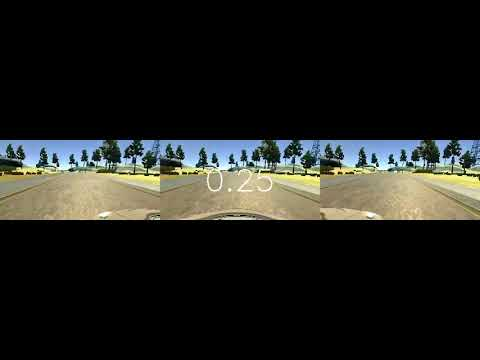

In [10]:
YouTubeVideo('6XYtevhMqd8')

### Recovery Data

One of the deficiencies of the above datasets is that they only tell the car what to do if it drives perfectly. We also need to teach the car to recover from *undesireable* positions. Therefore, we augment the above scene data with a recovery dataset:

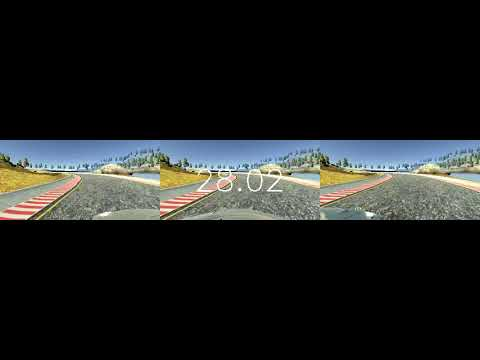

In [11]:
YouTubeVideo('E87PuoBO4n8')

Note that these maneuvers are intentionally very slow so that we can emphasize how exactly to make the corrections. Usually, the recover maneuvers start at the sides, and end in the middle. The speed is unimportant since we are not training the car's speed in this project.  

## Data Exclusion and Selection

### Loading the images

To make the code modular and easy to use, we have made one function responsible for specifying where the log folders live on your computer (`getLogFolders`), and one function for loading data from them (`loadData`). Both of these functions live in `loader.py`.

> The data that we use to train and validate the network have been posted as a [release in our Github repo.](https://github.com/mholzel/BehavioralCloning/releases/download/data/sims.tar). You can extract them wherever you like, but you will need to update the `getLogFolders` function as well as the image paths in the `driving_log.csv` files to reflect where you extracted the files. 

In [12]:
import loader
logs, offsets = loader.getLogFolders()
print("Log folders:")
print("\n".join(logs))
print()

labels = ['Center  ', 
          'Left    ', 
          'Right   ',
          'Angle   ',
          'Throttle',
          'Brake   ',
          'Speed   ' ]
samples = loader.loadData(logs, offsets)
for i in range(0,2):
    print("Sample example from dataset "+ str(i)+":")
    for label, elem in zip(labels,samples[i][0]):
        print(label + " : " + elem)
    print()

Log folders:
C:/Users/matth/Desktop/sims/bridge
C:/Users/matth/Desktop/sims/curve1
C:/Users/matth/Desktop/sims/curve2
C:/Users/matth/Desktop/sims/curve3
C:/Users/matth/Desktop/sims/recovery
C:/Users/matth/Desktop/sims/straightaway1

Sample example from dataset 0:
Center   : C:\Users\matth\Desktop\sims\bridge\IMG\center_2017_10_27_20_37_05_289.jpg
Left     : C:\Users\matth\Desktop\sims\bridge\IMG\left_2017_10_27_20_37_05_289.jpg
Right    : C:\Users\matth\Desktop\sims\bridge\IMG\right_2017_10_27_20_37_05_289.jpg
Angle    : 0.0
Throttle : 0
Brake    : 0
Speed    : 4.756187E-06

Sample example from dataset 1:
Center   : C:\Users\matth\Desktop\sims\curve1\IMG\center_2017_10_27_20_27_04_641.jpg
Left     : C:\Users\matth\Desktop\sims\curve1\IMG\left_2017_10_27_20_27_04_641.jpg
Right    : C:\Users\matth\Desktop\sims\curve1\IMG\right_2017_10_27_20_27_04_641.jpg
Angle    : 0.0
Throttle : 0
Brake    : 0
Speed    : 6.633341E-06



### Left/Center/Right Images

There is certainly information to be had by including the left and right images from the car. They give us a very clear view of the lanes in most cases. However, including them in the dataset also drastically increases the size of the neural net. Therefore, we are going to see if we can get away with just using the center images (spoiler alert: we can). By ignoring the the left and right images, we should also be able to drastically reduce processing time because we are essentially dealing with 1/3 of the original dataset. 

### Images with Steering Angles Near 0
As with the key-based steering approach, there is still a slight problem with the mouse-based approach in that we may have times when we accidentally let off of the mouse. When this occurs, the steering angle jumps from whatever it was to 0. This is almost never desired behvaior, so it is adviseable to remove all images with a steering angle of approximately zero. Very rarely was this actually the intended behavior. To accomplish this, we created a `utils` package containing several useful functions for manipulating our dataset. 

In [13]:
def sampleInfo(samples, label = ''):
    L = 0
    for s in samples:
        L += len(s)
    print(label + " : " +  str(len(samples)) + ' datasets with a combined ' + str(L) + ' samples' )

import utils
sampleInfo(samples, 'Original')
samples = utils.nonzeros(samples)
sampleInfo(samples, 'Nonzeros')

Original : 6 datasets with a combined 8354 samples
 165 samples removed  (24.264706%) with driving angles of approximately 0
 515 samples retained (75.735294%)
------------------------
 169 samples removed  (12.812737%) with driving angles of approximately 0
1150 samples retained (87.187263%)
------------------------
 243 samples removed  (28.321678%) with driving angles of approximately 0
 615 samples retained (71.678322%)
------------------------
 121 samples removed  (10.134003%) with driving angles of approximately 0
1073 samples retained (89.865997%)
------------------------
  74 samples removed  (3.093645%) with driving angles of approximately 0
2318 samples retained (96.906355%)
------------------------
 162 samples removed  (8.477237%) with driving angles of approximately 0
1749 samples retained (91.522763%)
------------------------
Nonzeros : 6 datasets with a combined 7420 samples


### Sorting and Chunking the data
Ultimately, we will need to split the data into training and validation sets. However, since we might like to add and remove datasets, we want to make sure that the same data will always land in the training and validation datasets regardless of which datasets are added and removed. We accomplish this by keeping the datasets separate until the very last moment before constructing the training and validation datasets. 

For instance, before we split the data, we want to sort and chunk the data. To understand what we mean by this, suppose that our "bridge" dataset included images with steering angles of 

`-1, ..., 0, 0.1, 0.2, ..., 10`

It would be really bad if the training set included all of the small samples, (like `-1, ..., 0.1`), while the validation set contained all of the large samples (`0.2, ..., 10`). The reason this would be bad is that the network would probably have a hard time extrapolating the small angle images to figure out what to do when it sees an image where a large steering angle is required. Furthermore, it would be doubly bad if the samples that ended up in the datasets changed when a new dataset (e.g. `curve4`), was added to the collection. This would be extremely bad because if the validation set suddenly contained images that were previously in the training set, it woud make the validation loss appear to be unreasonably good. Therefore to make our selection a little bit more even and predictable, we first sort the datasets based on the steering angles:

In [14]:
chunk_size = 10

print('The first ' + str(2*chunk_size) + ' angles in the first dataset BEFORE sorting')
print([ '{0:.2f}'.format(float(samples[0][i][3])) for i in range(2*chunk_size) ])
print()

samples = utils.sort(samples)
sampleInfo(samples, 'Sorted')
print()

print('The first ' + str(2*chunk_size) + ' angles in the first dataset AFTER sorting')
print([ '{0:.2f}'.format(float(samples[0][i][3])) for i in range(2*chunk_size) ])

The first 20 angles in the first dataset BEFORE sorting
['0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.00', '0.00', '0.00', '0.00']

Sorted : 6 datasets with a combined 7420 samples

The first 20 angles in the first dataset AFTER sorting
['-0.08', '-0.08', '-0.08', '-0.07', '-0.05', '-0.04', '-0.04', '-0.04', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03']


Then we chunk this data into smaller datasets: 

In [15]:
samples = utils.chunk(samples, n=chunk_size)
sampleInfo(samples, 'Chunked')

print()
print('Number of samples in the first 20 datasets:')
print([ len(samples[i]) for i in range(20) ])
print()
print('The first dataset:')
print([ '{0:.2f}'.format(float(sample[3])) for sample in samples[0] ])

print()
print('The second dataset:')
print([ '{0:.2f}'.format(float(sample[3])) for sample in samples[1] ])

Chunked : 744 datasets with a combined 7420 samples

Number of samples in the first 20 datasets:
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

The first dataset:
['-0.08', '-0.08', '-0.08', '-0.07', '-0.05', '-0.04', '-0.04', '-0.04', '-0.03', '-0.03']

The second dataset:
['-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03', '-0.03']


As you can see, instead of a small number of large datasets, we now have a large number of small datasets. At this point, we can randomly shuffle the data without having to worry about there being an unequal distribution of angles between the training and validation dataset because each of the datasets should contain images with similar steering angles. 

### Training and Validation Data
Finally, we split the data into training and validation datasets:

In [16]:
train_samples, valid_samples = utils.split(samples, train_percent=.7)
print(" Training  samples: ", len(train_samples))
print("Validation samples: ", len(valid_samples))

 Training  samples:  5192
Validation samples:  2228


## Data Generators
As you can see, we will be dealing with a lot of images (actually this is nothing compared to some machine learning projects that train on millions of images). Hence we aren't even going to try to load all of the images into RAM. Instead we are going to define a generator that supplies small batches of data from the larger pool of images. Specifically, our GPU (a GTX 1080) seems to be capable of handling 2048 of our images in each training batch, so we are going to create a generator that supplies that many images at each call. To accomplish this, we will use the `sampleGenerator` method of `source.py`, which takes in a large dataset of samples, and returns a small subset of those images at each iteration. For instance, given the above training and validation datasets, we can create generators form them like this:

In [17]:
import source
batch_size = 2048
train_generator = source.sampleGenerator(train_samples, batch_size=batch_size)
valid_generator = source.sampleGenerator(valid_samples, batch_size=batch_size)

# Make sure that the generators are really giving us batches of the specified size
print("Batches have size:", len(next(train_generator)[0]))

Batches have size: 2048


> Actually, the generators return numpy arrays containing the images, as well as the desired steering angles.

### Flipped Images
We are going to drive around the test track counter-clockwise, which will probably introduce a bias to turn the car left. If all of the turns were left-hand turns, then this wouldn't really be a problem, but since the last turn is a right-hand turn, then this could be a big problem indeed. There are generally two ways of solving this:

1. We could simply include another dataset emphasizing the last right-hand turn. 
   - Problem: There are many more left turns than right turns, so to have any meaningful effect, we would probably have to do a ton of runs on the right hand turn to balance out the dataset. If we only included a few runs through the right-hand turn, then chances are that the data would essentially be viewed as "noise" by the optimization, and ignored.  
2. We can augment the dataset with flipped images.

The second solution is the preferred approach because we will always have a reciprocal image that should essentially balance out any left/right bias. For every image turning left, there will be an image turning right. You can't get much more balanced than that. 

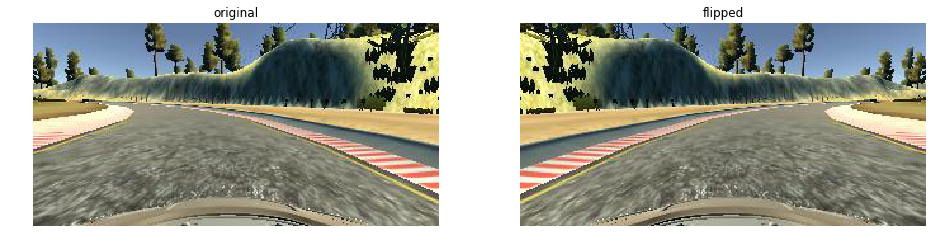

In [18]:
import cv2

image = mpimg.imread('images/center.jpg')

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(1,2,1)
ax.imshow(image)
ax.axis('off')
plt.title('original');

ax = plt.subplot(1,2,2)
ax.imshow(cv2.flip(image, 1))
ax.axis('off')
plt.title('flipped');

To use generators that also contain the flipped images, we therefore change our generators to those created by `sampleGeneratorWithFlipped`. Unlike the `sampleGenerator` method, this method returns batches containing the original images and their flipped versions. This ensures that the network never sees a left-hand turn without a right-hand turn. The only caveat of this method is that each batch will actually be twice the passed-in size. So we have to half our ideal batch size to create the generators:

In [19]:
include_flipped = True
if include_flipped:
    batch_size = batch_size // 2
    train_generator = source.sampleGeneratorWithFlipped(train_samples, batch_size=batch_size)
    valid_generator = source.sampleGeneratorWithFlipped(valid_samples, batch_size=batch_size)

# Make sure that the generators are really giving us batches of the specified size
print("Batches have size:", len(next(train_generator)[0]))

Batches have size: 2048


## The Network!

Finally, we can talk about the network. But before we get there, some quick comments... 

1. You may have noticed that we really didn't do any preprocessing on the dataset aside from selecting which images to include/exclude. For instance, we didn't convert the images to grayscale, crop the images, or do any normalization. The reason is simply that we want our network to be directly insertable to a pipeline for autonomous driving. The pipeline doesn't know which information we want, so we are going to build that information directly into the network. 

1. We are going to into detail about each of the layers in the model we are using. However, for simplicity, they are encapsulated in `get` method of `nn.py`. So if you just want to see the results, you can use that function. 

1. You should not get super hung up on the hyperparameters that we choose here. I believe that any sufficiently deep model would be able to capture the same behavior with enough training and regularization.

So without further ado, let's talk about the model... 

First of all, we are going to be building up a pretty tame sequential model: 

In [20]:
from keras.models import Sequential
model = Sequential()

Using TensorFlow backend.


### Cropping

Next, we are going to crop away a lot of the image, because things like the scenary and hood of the car should have no effect on the steering angle we decide to use. Specifically, from an initial (width,height) of (320x160), we are going to remove the top 80 pixels, and bottom 40 pixels, leaving us with just the relevant lane data in a comapct (320x40) image:

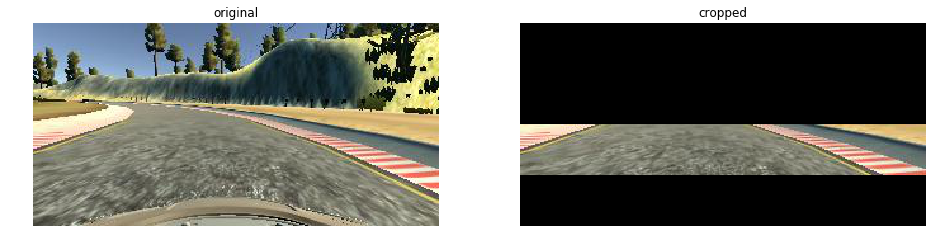

In [21]:
import numpy

image = mpimg.imread('images/center.jpg')

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(1,2,1)
ax.imshow(image)
ax.axis('off')
plt.title('original');

ax = plt.subplot(1,2,2)
cropped = numpy.zeros_like( image )
cropped[80:120,:,:] = image[80:120,:,:]
ax.imshow(cropped)
ax.axis('off')
plt.title('cropped');

from keras.layers import Cropping2D
crop = (80, 40)
rows = 160
cols = 320
channels = 3
model.add(Cropping2D(cropping=(crop, (0, 0)), input_shape=(rows, cols, channels)))

You might also want to consider cropping out some of the middle of the image, since it seems to just show raw pavement. However, some of the recovery images contain lane data very close to the image center, so we do not do this. For instance, here is one of the cropped recovery images:

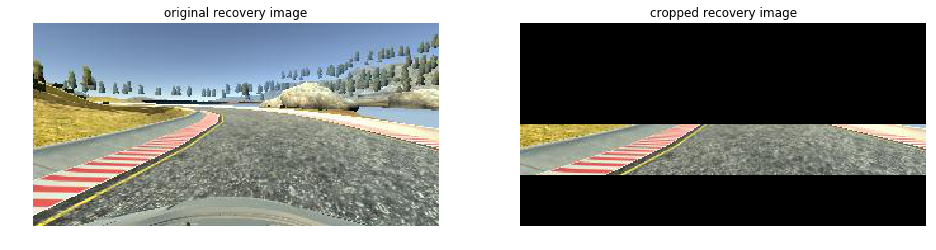

In [22]:
image = mpimg.imread('images/recovery.jpg')

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(1,2,1)
ax.imshow(image)
ax.axis('off')
plt.title('original recovery image');

ax = plt.subplot(1,2,2)
cropped = numpy.zeros_like( image )
cropped[80:120,:,:] = image[80:120,:,:]
ax.imshow(cropped)
ax.axis('off')
plt.title('cropped recovery image');

### Grayscale
Next, we are going to convert the images to grayscale since the colors don't really buy us anything. At it's core, one would suspect that a successful car would essentially just be looking for lines on the road, and color doesn't really help us out with that. To add a grayscale layer to our model, we would like to use a `Lambda` function. However, these functions create a problem when loading saved models on Windows machines. Hence the work-around is to create custom layers, which are more verbose forms of essentially the same thing. We have put our custom layers in `customlayers.py`. So adding a grayscale layer to our model is as simple as:

In [23]:
import customlayers 
model.add(customlayers.Grayscale())

### Normalization

Before getting to the fun stuff, the last "preprocessing" step we need to implement is image normalization, that is, changing the image pixel ranges from [0, 255] to [-1, 1]. This is extremely important for the optimizer, since having well-scaled data can make it much easier (and hence faster) for the optimizer to find a minimum. Again, since Lambda functions cause problems on Windows machines, we created another custom layer that performs image normalization:

In [24]:
model.add(customlayers.Normalizer())

### The Rest of the Model

When selecting the rest of the layers, we want to stick with trends that have been successful in other projects. That means a few convolutional layers that are increasing in size, followed by some dense layers which decrease in size. Furthermore, each convolutional layer is followed by a max-pooling operation, while each dense layer is followed by dropout. Hence the rest of the model is defined like this:

In [25]:
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

dropout = 0.1
depths = [10,20,30,100,50]

i = 0
model.add( Conv2D(depths[i], (7, 7), activation="relu", strides=(1, 2)))
i += 1
model.add( MaxPooling2D(pool_size=(1, 2)))

model.add( Conv2D(depths[i], (7, 7), activation="relu", strides=(1, 2)))
i += 1
model.add( MaxPooling2D(pool_size=(2, 2)))

model.add( Conv2D(depths[i], (5, 5), activation="relu", strides=(1, 1)))
i += 1
model.add( MaxPooling2D(pool_size=(2, 2)))

model.add( Flatten())

model.add( Dropout(dropout))
model.add( Dense(depths[i], activation="relu"))
i += 1
model.add( Dropout(dropout))
model.add( Dense(depths[i], activation="relu"))
i += 1
model.add( Dropout(dropout))
model.add( Dense(1))

One of the things to note about this model is that it still keeps the number of parameters relatively small (I guess this is in the eye of the beholder). However, we keep overfitting in check by using several dropout layers.

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 40, 320, 3)        0         
_________________________________________________________________
grayscale_1 (Grayscale)      (None, 40, 320, 1)        0         
_________________________________________________________________
normalizer_1 (Normalizer)    (None, 40, 320, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 157, 10)       500       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 78, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 36, 20)        9820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 18, 20)        0         
__________

To make modifying the hyperparameters easier, we encapsulated this architecture in the `get` method of `nn.py`. That is, to create the same model using the `get` method, the only mandatory requirement is the definition of the `depths` vector (although you can also toggle grayscale/rgb, change the input dimensions, dropout values, etc.):

In [27]:
import nn 
gray = True
model = nn.get(depths, gray = gray, dropout=dropout)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 40, 320, 3)        0         
_________________________________________________________________
grayscale_2 (Grayscale)      (None, 40, 320, 1)        0         
_________________________________________________________________
normalizer_2 (Normalizer)    (None, 40, 320, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 157, 10)       500       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 78, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 36, 20)        9820      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 18, 20)        0         
__________

## Training

To train the aforementioned network, we will run an Adam optimizer for 1000 epochs in an attempt to minimize the mean-squared error (`mse`) in steering angle predictions. Furthermore, we will keep track of the training and validation loss during training so that we can determine whether overfitting is occurring. 

> The following code only runs 1 epoch. But to generate the model, we ran 1000. 

In [28]:
import math, os

# The first thing we need to do is to compile the model. 
loss = 'mse'
model.compile(loss=loss, optimizer='adam')

# Next, create the name of the model which tells us what parameters were used to set up the model
name = 'model2_'
name += loss + '_'
name += ('gry' if gray else 'rgb') + '_'
name += 'dropout_' + "{0:.3f}".format(dropout) + '_'
name += ('flipped' if include_flipped else 'no_flip') + '_'
name += 'depths_' + "_".join((str(i) for i in depths))

# Next, we create a callback that will keep track of the loss history
# and a callback that will save the best models during training.
import keras
lossHistory = keras.callbacks.History()
savePath = os.path.join('models', name) + "_epoch_{epoch:02d}_loss_{loss:3.3f}_valloss_{val_loss:3.3f}.h5"
checker = keras.callbacks.ModelCheckpoint(savePath, save_best_only=True, monitor='val_loss', verbose=1,
                                          mode='auto')

# When fitting a generator, you don't have to use all of the data in each epoch, but we want to
steps_per_epoch  = math.ceil( len(train_samples) / batch_size )
validation_steps = math.ceil( len(valid_samples) / batch_size )
model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=1,
                    validation_data=valid_generator,
                    validation_steps=validation_steps,
                    callbacks=[lossHistory, checker])

# Save the model and a log with all of the losses
model.save(name + '.h5')
with open(name + '.log', 'w') as file:
    file.write(str(lossHistory.history))

Epoch 1/1
6/6 [==============================] - 13s - loss: 201.4925 - val_loss: 188.0018


## Autonomous Runs

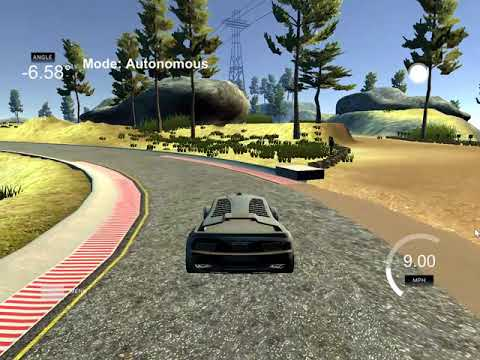

In [29]:
YouTubeVideo('Iea3KqRKhio')

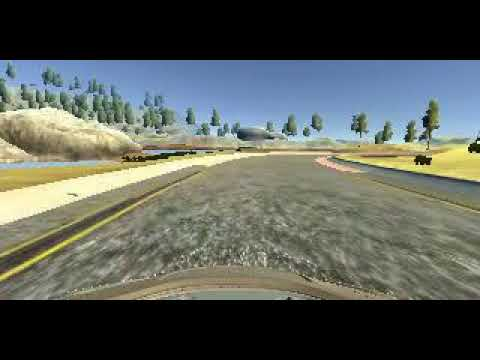

In [30]:
YouTubeVideo('bz04qqqcQXY')